# Linear State Space Models, Asset Pricing, and the Kalman Filter

Undergraduate Computational Macro

Jesse Perla (University of British Columbia)

# Overview

## Motivation and Materials

-   In this section we introduce a class of dynamic models that are
    widely used in economics and finance
-   Unlike the previous sections, we will be separating out the
    equations for the “evolution” of the state and the “observation”
-   The main applications will be some simple models of asset pricing,
    but we will use this machinery in the next section on the permanent
    income model
-   For the asset pricing examples, we will be building off the
    deterministic versions we discussed
    [previously](https://jlperla.github.io/ECON408/lectures/geometric_series_fixed_points.html#/asset-pricing-and-fixed-points)
-   Finally, we will introduce the Kalman Filter: a workhorse for
    estimation, implementing learning in dynamic models, and machine
    learning

## Materials

-   Adapted from QuantEcon lectures coauthored with John Stachurski and
    Thomas J. Sargent
    -   [Linear State Space
        Models](https://julia.quantecon.org/introduction_dynamics/linear_models.html#the-linear-state-space-model)
    -   [A First Look at the Kalman
        Filter](https://julia.quantecon.org/introduction_dynamics/kalman.html)
-   The new package, `QuantEcon.jl` is used for some of the code
    examples for easy simulation

In [1]:
using Distributions, Plots, LaTeXStrings, LinearAlgebra, Statistics
using Plots.PlotMeasures, QuantEcon, StatsPlots
default(;legendfontsize=16, linewidth=2, tickfontsize=12,
         bottom_margin=15mm)

# Linear State Space Models

## State Space Models

-   State space models describe state and observation dynamics
    -   $x_t \in \mathbb{R}^n$ denoting the **state**, which may be
        “latent”
    -   $y_t\in\mathbb{R}^k$ **observables** of that state
    -   $w_{t+1}  \in \mathbb{R}^m$ **shocks** which cannot be
        forecasted
-   Where the model includes a pair of equations
    -   A law of motion of a state variable $x_t$ (the “evolution
        equation”)
    -   A law of motion of the observables $y_t$ given the state $x_t$
        (the “observation equation”)
-   A recursive, Markovian model is the goal. Linearity is convenient

## Primitives for a LSS

-   $A\in\mathbb{R}^{n\times n}$ **transition matrix**
-   $C \in \mathbb{R}^{n\times m}$ **volatility matrix**
-   $G \in \mathbb{R}^{k\times n}$ **observation matrix** (or output
    matrix)
-   Then the LSS is given by $$
    \begin{aligned}
      x_{t+1} & =  A x_t + C w_{t+1},&\text{ evolution equation}  \\
      y_t &=  G x_t,&\text{ observation equation} \\
      w_{t+1} &\sim \mathcal{N}(0,I) &\text{ shocks}
    \end{aligned}
    $$

## Initial Conditions

-   The initial condition $x_0$ could be given, or it could be a
    distribution

-   Given $\mu_0 \in \mathbb{R}^n$ and
    $\Sigma_0 \in \mathbb{R}^{n\times n}$, a (positive semi-definite)
    covariance matrix $$
    x_0  \sim \mathcal{N}(\mu_0, \Sigma_0)
    $$

    -   Note that if $\Sigma_0 = \begin{bmatrix}0\end{bmatrix}$ then
        $x_0 = \mu_0$ deterministically
    -   Later, when we discuss the Kalman Filter, we will consider this
        as a “prior” distribution over possible $x_0$ states

## Example: Difference Equation

-   Let $\{y_t\}$ be a deterministic sequence that satisfies $$
    y_{t+1} =  \phi_0 + \phi_1 y_t + \phi_2 y_{t-1}
    $$

    -   Given a $y_0, y_{-1}$
    -   Map this into the LSS by choosing a $x_t$
    -   “Finding the state is an art”

## Example: Difference Equation in LSS

-   Fulfill: $y_{t+1} =  \phi_0 + \phi_1 y_t + \phi_2 y_{t-1}$
-   Define $x_t =\begin{bmatrix}1 & y_t & y_{t-1}\end{bmatrix}^{\top}$,
    $w_{t+1} \in \mathbb{R}^1$ $$
    \begin{aligned}
    \underbrace{\begin{bmatrix}1 \\ y_{t+1} \\ y_{t}\end{bmatrix}}_{\equiv x_{t+1}} &= \underbrace{\begin{bmatrix}1 & 0 & 0 \\ \phi_0 & \phi_1 & \phi_2  \\ 0 & 1 & 0\end{bmatrix}}_{\equiv A} \underbrace{\begin{bmatrix}1 \\ y_t \\ y_{t-1}\end{bmatrix}}_{\equiv x_t} + \underbrace{\begin{bmatrix}0 \\ 0 \\ 0\end{bmatrix}}_{\equiv C} \underbrace{\begin{bmatrix}w_{t+1}\end{bmatrix}}_{\equiv w_{t+1}}\\
    y_t &= \underbrace{\begin{bmatrix}0 & 1 & 0\end{bmatrix}}_{\equiv G} \underbrace{\begin{bmatrix}1 \\ y_t \\ y_{t-1}\end{bmatrix}}_{\equiv x_t}
    \end{aligned}
    $$

## Simulation


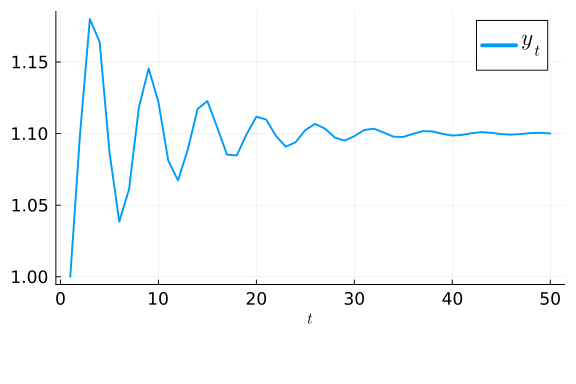

In [1]:
phi0, phi1, phi2 = 1.1, 0.8, -0.8
A = [1.0 0.0 0
     phi0 phi1 phi2
     0.0 1.0 0.0]
C = zeros(3, 1)
G = [0.0 1.0 0.0]
y_0 = 1.0
y_m1 = 1.0
mu_0 = [1.0, y_0, y_m1]
lss = LSS(A, C, G; mu_0)
x, y = simulate(lss, 50)
plot(y'; xlabel = L"t", label = L"y_t",
         size=(600, 400))

## Example: Auto-Regressive Process

-   Fulfill:
    $y_{t+1} = \phi_1 y_{t} + \phi_2 y_{t-1} + \phi_3 y_{t-2} + \phi_4  y_{t-3} + \sigma w_{t+1}$

$$
\begin{aligned}
\underbrace{\begin{bmatrix}y_{t+1} \\ y_{t} \\ y_{t-1} \\ y_{t-2}\end{bmatrix}}_{\equiv x_{t+1}} &= \underbrace{\begin{bmatrix}\phi_1 & \phi_2 & \phi_3 & \phi_4 \\ 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0\end{bmatrix}}_{\equiv A} \underbrace{\begin{bmatrix}y_t \\ y_{t-1} \\ y_{t-2} \\ y_{t-3}\end{bmatrix}}_{\equiv x_t} + \underbrace{\begin{bmatrix}\sigma \\ 0 \\ 0 \\ 0\end{bmatrix}}_{\equiv C} \underbrace{\begin{bmatrix}w_{t+1}\end{bmatrix}}_{\equiv w_{t+1}}\\
y_t &= \underbrace{\begin{bmatrix}1 & 0 & 0 & 0\end{bmatrix}}_{\equiv G} \underbrace{\begin{bmatrix}y_t & y_{t-1} & y_{t-2} & y_{t-3}\end{bmatrix}^{\top}}_{\equiv x_t}
\end{aligned}
$$

## Simulation


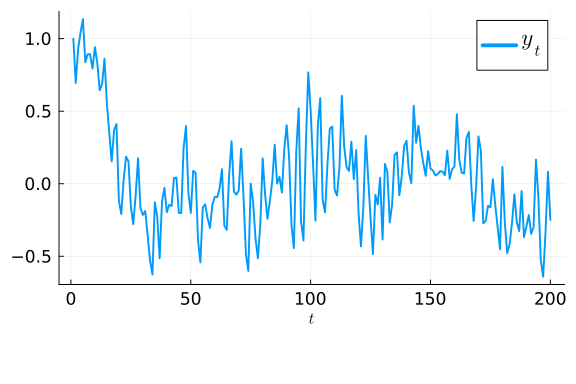

In [1]:
phi1, phi2, phi3, phi4 = 0.5, -0.2, 0, 0.5
sigma = 0.2
A = [phi1 phi2 phi3 phi4
     1.0 0.0 0.0 0.0
     0.0 1.0 0.0 0.0
     0.0 0.0 1.0 0.0]
C = [sigma
     0.0
     0.0
     0.0]
G = [1.0 0.0 0.0 0.0]
mu_0 = ones(4)
lss = LSS(A, C, G; mu_0)
x, y = simulate(lss, 200)
plot(y'; xlabel = L"t", label = L"y_t",
         size=(600, 400))

## Moments and Forecasts

-   Given $x_t \sim \mathcal{N}(\mu_t, \Sigma_t)$, can forecast
    $x_{t+1} \sim \mathcal{N}(\mu_{t+1}, \Sigma_{t+1})$ $$
    \begin{aligned}
    \mu_{t+1} &= A \mu_t\\
    \Sigma_{t+1} &= A \Sigma_t A^{\top} + C C^{\top}
    \end{aligned}
    $$

-   And given some $x_t\sim \mathcal{N}(\mu_t, \Sigma_t)$

    $$
    y_{t+1} \sim \mathcal{N}(G \mu_t, G \Sigma_t G^{\top})
    $$

## Forecasts and Expected Net Present Values

-   Given $x_t \sim \mathcal{N}(\mu_t, \Sigma_t)$, we can forecast
    $x_{t+j}$ and $y_{t+j}$ for any $j$ $$
    \begin{aligned}
    \mathbb{E}_t x_{t+j} &= A^j \mu_t\\
    \mathbb{E}_t y_{t+j} &= G A^j \mu_t
    \end{aligned}
    $$

-   Useful for computing expected net present values of future cash
    flows

    $$
    \begin{aligned}
    \mathbb{E}_t \sum_{j=0}^{\infty} \beta^j y_{t+j} &= \sum_{j=0}^{\infty} \beta^j \mathbb{E}_t y_{t+j} = \sum_{j=0}^{\infty} \beta^j G A^j \mu_t\\
    &= G(I - \beta A)^{-1} \mu_t
    \end{aligned}
    $$

## Stationary Distributions

-   If they exist, from any gaussian initial condition, the stationary
    distribution is
    $x_{\infty} \sim \mathcal{N}(\mu_{\infty}, \Sigma_{\infty})$

-   Must fulfill the fixed points of the previous iteration,

    $$
    \begin{aligned}
    \mu_{\infty} &= A \mu_{\infty}\\
    \Sigma_{\infty} &= A \Sigma_{\infty} A^{\top} + C C^{\top}
    \end{aligned}
    $$

    -   The first is an eigenvalue problem
    -   The second is a discrete [Lyapunov
        equation](https://en.wikipedia.org/wiki/Lyapunov_equation)

# Introduction to the Kalman Filter

## Noisy Observation Equation

-   Given $A$ and $G$ matrices, you may be able to recover $x_t$ from
    the $y_t$

-   What if the observations in the LSS are noisy? Then $x_t$ is truly
    “latent” $$
    \begin{aligned}
        x_{t+1} & =  A x_t + C w_{t+1}   \\
        y_t &  =  G x_t + H v_t\\
        w_{t+1} &\sim \mathcal{N}(0,I)\\
        v_t &\sim \mathcal{N}(0, I)
    \end{aligned}
    $$

    -   If $H = \begin{bmatrix}0\end{bmatrix}$, then noiseless
        observation

## Tracking the Distribution of the State

-   Can the latent $x_t$ state be estimated from the noisy
    $\{y_0, \ldots y_t\}$ observations?
-   Then we can forecast the state $x_{t+j}$ and future observables
    $y_{t+j}$
    -   However, we also need to “nowcast” the state $x_t$ since the
        state is unknown and our observations are noisy
-   If we assume that $x_0 \sim \mathcal{N}(\mu_0, \Sigma_0)$, then we
    interpret this as a “prior” distribution over the possible states of
    $x_0$
-   In that case, we use the $y_1$ observation to update our beliefs
    about the state $x_0$ to get a new distribution over the state $x_0$
-   This is a [Bayesian](https://en.wikipedia.org/wiki/Bayes%27_theorem)
    approach,
    $\mathbb{P}(x_t|y_t, y_{t-1}, \ldots) \propto \mathbb{P}(y_t | x_t)\mathbb{P}(x_t|y_{t-1}, \ldots)$

## Bayesian Approach with Normal Distributions

-   In particular, we want to take our “prior”
    $x_0 \sim \mathcal{N}(\mu_0, \Sigma_0)$ and $y_1$ to build new
    beliefs about $x_1 \sim \mathcal{N}(\mu_1, \Sigma_1)$
    -   This is more complicated than a normal Bayesian update because
        the $x_t$ is moving with the evolution equation
-   The key here, as with our [derivation with the
    AR(1)](https://jlperla.github.io/ECON408/lectures/stochastic_dynamics.html#/evolution-of-the-ar1-process)
    is that a [linear combination of Gaussians is
    Gaussian](https://jlperla.github.io/ECON408/lectures/stochastic_dynamics.html#/normal-random-variables-1)
-   Because of this, it is sufficient to write a recurrence for $\mu_t$
    and $\Sigma_t$
    -   Given $x_t \sim \mathcal{N}(\mu_t, \Sigma_t)$ and $y_{t+1}$ what
        is $x_{t+1} \sim \mathcal{N}(\mu_{t+1}, \Sigma_{t+1})$?

## Kalman Filter

-   The Kalman Filter is the recursive, Bayesian updating of the
    distribution of the state $x_{t+1}$ given the observations $y_{t+1}$
    and a prior $x_t \sim \mathcal{N}(\mu_t, \Sigma_t)$

-   See
    [here](https://julia.quantecon.org/introduction_dynamics/kalman.html)
    and other places for the derivation $$
    \begin{aligned}
      K_t &\equiv A \Sigma_t G^{\top} (G \Sigma_t G^{\top} + H H^{\top})^{-1}\\
      \mu_{t+1} &= A \mu_t + K_t (y_t - G \mu_t) \\
      \Sigma_{t+1} &= A \Sigma_t A^{\top} - K_t G \Sigma_t A^{\top} + C C^{\top}
    \end{aligned}
    $$

    -   $K_t$ is the “Kalman Gain” and $y_t - G \mu_t$ is called the
        “innovation”
    -   The last equation is called a matrix Ricatti equation

The [Kalman
Smoother](https://en.wikipedia.org/wiki/Kalman_filter#Fixed-lag_smoother)
is when you go back at time $t$ and update all of your previous
distributions $\{x_0,\ldots x_{t-1}\}$ given **all** of the observations
$\{y_0,\ldots y_t\}$.

## Interpreting the Gain

-   Consider the simple case where
    $x_t \in \mathbb{R}, y_t \in \mathbb{R}, A = 1, G = 1$ and
    $C,H \in \mathbb{R}$ $$
    \begin{aligned}
    K_t &= \Sigma_t/(\Sigma_t + H^2)\\
    \mu_{t+1} &= \mu_t + K_t \underbrace{(y_t - \mu_t)}_{\text{innovation}} = (1-K_t)\mu_t + K_t y_t\\
    \Sigma_{t+1} &= (1-K_t)\Sigma_t + C^2
    \end{aligned}
    $$

    -   The $\mu_{t+1}$ equation is a weighted average of the forecast
        (i.e. $\mu_t$ since $A=1$) and the observation $y_t$
    -   $K_t$ says how much to update the forecast of the mean. Small
        “gain” means less weight on new observations

## Forecasting and Nowcasting

-   Future states are forecasted by the Kalman Filter itself

-   The state is a hidden Markov variable, but we can forecast the
    current state and future observations

-   Current state is constructed to be
    $x_t \sim \mathcal{N}(\mu_t, \Sigma_t)$

-   Given a $x_t$ distribution, can get the $y_t$ distribution as

    $$
    y_t \sim \mathcal{N}(G \mu_t, G \Sigma_t G^{\top} + H H^{\top})
    $$

    -   Useful for forcasting (i.e., what would the observation
        distribution be for a future distribution)
    -   Also useful for estimation and likelihoods in structural models

## Different Canonical Forms

-   When looking at software packages, you may need to map to different
    version

-   For example, another common one is $$
    \begin{aligned}
        x_{t+1} & =  A x_t + w_{t+1}   \\
        y_t &  =  G x_t + v_t\\
        w_{t+1} &\sim \mathcal{N}(0,Q)\\
        v_t &\sim \mathcal{N}(0, R)
    \end{aligned}
    $$

    -   Which maps to ours if $Q = C C^{\top}$ and $R = H H^{\top}$  
    -   Can go other direction with a Cholesky decomposition
    -   Others may have an additional “control” term in the $x_{t+1}$
        equation

## Example Implementation

-   We will use the `QuantEcon.jl` package for the Kalman Filter, uses
    the $Q$ and $R$ form

-   Consider a univariate function

    $$
    \begin{aligned}
    x_{t+1} &= x_t\\
    y_t &= x_t + v_t\\
    v_t &\sim \mathcal{N}(0, 1.0^2)
    \end{aligned}
    $$

    -   We will assume that $x_0 \sim \mathcal{N}(8.0, 1.0^2)$
    -   We will assume that the true $x_0 = 10.0$ and hence $x_t = 10.0$
        for all $t$

## Simulation


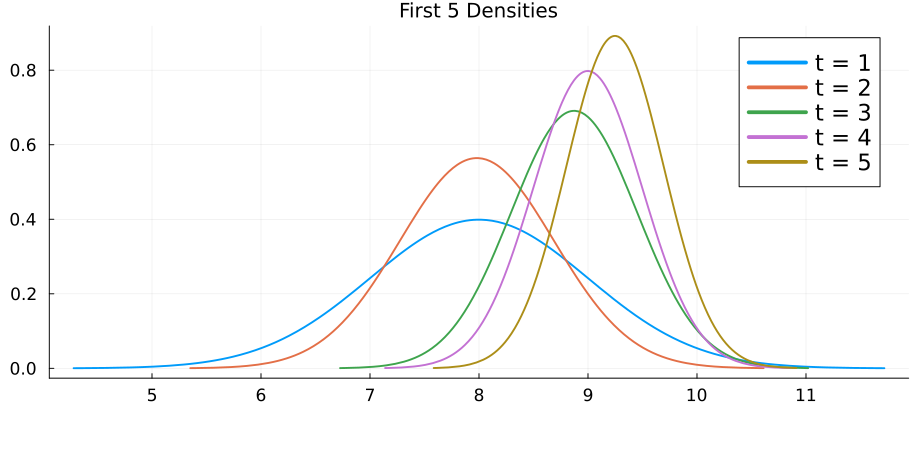

In [1]:
A, G, Q, R = 1.0, 1.0, 0.0, 1.0
x_hat_0, Sigma_0 = 8.0, 1.0
x_true = 10.0
# initialize Kalman filter
kalman = Kalman(A, G, Q, R)
set_state!(kalman, x_hat_0, Sigma_0)
plt = plot(;title="First 5 Densities")
for i in 1:5
    # record the current predicted mean and variance, and plot their densities
    m, v = kalman.cur_x_hat, kalman.cur_sigma
    plot!(Normal(m, sqrt(v)); label = "t = $i")
    # Generate signal and update
    y = x_true + sqrt(R) * randn() # i.e. x_t + v_t
    update!(kalman, y)
end
plt

## Applications of the Kalman Filter

-   The LSS with noisy observation is an example of a “hidden Markov
    model”
    -   i.e., Observe only a noisy version of a Markovian state
-   The Kalman Filter is used in many applications
    -   Estimating and forecasting the state of the economy given noisy
        data
    -   Estimating the state of a latent variable or forming a
        likelihood in a structural model
    -   Machine learning and reinforcement learning (e.g., estimating
        the position of a car or pedestrian given noisy sensor data)
    -   [Apollo
        11](https://www.lancaster.ac.uk/stor-i-student-sites/jack-trainer/how-nasa-used-the-kalman-filter-in-the-apollo-program/)
        used a Kalman Filter to estimate the position of the spacecraft

# Models of Expectations

## Forecasts and Expectations

-   The emphasis on stochastic processes serves a dual role
    1.  Model of the economy which you can conduct quantitative
        experiments as an “econometrician”
    2.  Model of the formation of expectations and the pricing of assets
        for an “agent” inside of the model
-   This wasn’t required when we have exogenously given, ad-hoc
    decisions like the savings rate previously
    -   But if we want to model agent decisions, they need to form
        expectations about the future
    -   Without that model of decisions, can we conduct policy
        counterfactuals?

## Alternative Approaches

-   The baseline approach for most of macroeconomics in the 1960s+ is
    called “rational expectations”
    -   Use the mathematical expectation, and assume agent’s have a
        well-specified model of the economy
-   Using that as a baseline, there are many models of **bounded
    rationality** which deviate from this in various ways
    -   e.g., what it agents don’t fully know the evolution of the
        economy but have priors (use Kalman Filter?)
    -   what is agent’s only learn from their own past observations? The
        oldest versions of this are called “adaptive expectations” and
        it is related to modern methods in machine learning

## Using the Mathematical Expectation

-   A good starting point for a model of expectations is to assume that
    agents use the mathematical expectation

-   This requires that they have an internal model of a stochastic
    process for the data-generating process - conditional on their
    choices

    -   Then they can use probabilities to calculated expected values

-   One benefit is that we can use the mathematical expectation and its
    properties (e.g., linearity)

    $$
    \mathbb{E}(a X + b Y | Z) = a \mathbb{E}(X|Z) + b \mathbb{E}(Y|Z)
    $$

    -   Requires a model of joint distribution of the data-generating
        process, and theory of which values to condition on

## Information Sets

-   Think of the values we can condition on in our expectations as being
    the “information set” of the agent

    -   For stochastic processes that unfold over time, a good default
        is to think of all information up to time $t$ being available
    -   Call this the “Information Set”. Shorthand denote with subscript

    $$
    \mathbb{E}[X_{t+1} | \underbrace{X_t, X_{t-1}, \ldots}_{\text{Information Set}}] = \mathbb{E}_t[X_{t+1}]
    $$

-   If Markov, information set is summarized by the current state

    $$
    \mathbb{E}[X_{t+1} | X_t, X_{t-1}, \ldots] = \mathbb{E}[X_{t+1} | X_t]
    $$

## Law of Iterated Expectations

-   Frequently you will find yourself taking expectations of future
    expectations
-   A useful property of mathematical expectations is the “Law of
    Iterated Expectations” $$
    \begin{aligned}
    \mathbb{E}_t[\mathbb{E}_{t+1}[X_{t+2}]] &= \mathbb{E}_t[X_{t+2}]\\
    \mathbb{E}[\mathbb{E}[X_{t+2} | X_{t+1}, X_t, \ldots] | X_t, X_{t-1}, \ldots] &= \mathbb{E}[X_{t+2} | X_t, X_{t-1}, \ldots]
    \end{aligned}
    $$

## Models of Learning a Hidden State

-   Specifying the information set is a key part of economic models

-   If a state is hidden, then the agent must expectations from
    observables

-   Models of learning a hidden value or latent state are often built
    around some form of state-space model

-   For example, with a LSS model $x_{t+1} =  A x_t + C w_{t+1}$ and
    $y_t =  G x_t + H v_t$

    $$
    \mathbb{E}(x_{t+1} | y_t, y_{t-1}, \ldots)
    $$

    -   In that case, could use a posterior probabilities from Kalman
        Filter

-   Not all models of learning are Bayesian, but economists often case
    about $$
    \mathbb{E}[(x_{t+1} - \mathbb{E}[x_{t+1}|y_t, y_{t-1}, \ldots])^2 | y_t, y_{t-1}, \ldots]
    $$

## Forecast Errors

-   With either a learning model or one with noiseless observations, we
    can define the one-period ahead forecast error as

$$
FE_{t,t+1} \equiv x_{t+1} - \mathbb{E}_t[x_{t+1}]
$$

-   With our LSS, the information sets are
    $x_{t+1}, w_{t+1}, x_t, w_t, \ldots$ vs. $x_t, w_t, \ldots$

$$
  FE_{t,t+1} = A x_t + C w_{t+1} - \mathbb{E}_t[A x_t + C w_{t+1}] = C w_{t+1}
  $$ - The forecast error is a random variable, but it is uncorrelated
with the information set

## Systematic Bias in Forecasts

-   How far off do you expect your forecasts to be?

    $$
    \mathbb{E}_t[FE_{t,t+1}] = \mathbb{E}_t[x_{t+1} - \mathbb{E}_t[x_{t+1}]] = 0
    $$

    -   That comes from the linearity of expectations
    -   A hallmark of rational expectations is that agents don’t
        systematically over or under-estimate the future
    -   If they did, why not just manually adjust fudge expectations?

## Variance of Forecast Errors

-   While there is no systematic bias, that doesn’t mean the forecasts
    are correct
-   In some cases the agent may care deeply about how precise they are
-   For a LSS we can calculate the variance (using the mean zero result)

$$
\begin{aligned}
\mathbb{V}_t(FE_{t+1}) &\equiv \mathbb{E}_t[FE_{t,t+1} FE_{t,t+1}^{\top}]\\
  &= \mathbb{E}_t[(C w_{t+1})(C w_{t+1})^{\top}] = C C^{\top}
\end{aligned}
$$

-   With the observation equation (and possible measurement error)

$$
\mathbb{V}_t(FE_{t+1}) = G C C^{\top} G^{\top} + H H^{\top}
$$

## Forecasting Error with Learning Models

-   If $x_t$ is not in the information set, then (conditional on $x_t$)
    the expected forecast error may not be zero.

    -   With a LSS and a Kalman Filter and
        $x_t \sim \mathcal{N}(\mu_t, \Sigma_t)$,

    $$
    \begin{aligned}
    FE_{t,t+1} &= y_{t+1} - \mathbb{E}[y_{t+1} | y_t, y_{t-1}, \ldots]\\
    &= G(A x_t + C w_{t+1}) - G(A \mu_t) = G A (x_t - \mu_t) + C w_{t+1}
    \end{aligned}
    $$

-   In that setup, the agent has an unbiased estimate if they use their
    $x_t$ estimate since $\mathbb{E}_t(x_t) = \mu_t$

    $$
    \mathbb{E}_t[FE_{t,t+1}] = \mathbb{E}_t[G A (x_t - \mu_t) + C w_{t+1}] = 0
    $$

## Martingales

-   An important type of stochastic process are Martingales where

    $$
    \mathbb{E}_t[X_{t+1}] = X_t
    $$

    -   i.e., in expectation, the future value is the current value
    -   Inductively you can see that $\mathbb{E}_t[X_{t+j}] = X_t$ for
        all $j$

-   The canonical Martingale is a random walk $X_{t+1} = X_t + w_{t+1}$
    where $w_{t+1}\sim \mathcal{N}(0,1)$

-   Forecasting: the best guess for the future is the current value

-   Martingales have many applications in asset pricing and finance,
    models of learning, and in consumption and savings models

# Risk-Neutral Asset Pricing

## Risk-Neutrality

-   Economically what does linearity in payoffs $u(c) = c$ mean?
    -   It means that the agent is “risk-neutral” and only cares about
        the expected value of the payoff
    -   This is a strong assumption, but it may be accurate in many
        cases (e.g., institutional investors)
-   Risk averse agents have concave utility functions, and risk-loving
    agents have convex utility functions
-   Linearity is especially useful for stochastic processes because we
    can use it with the mathematical expectation

## Risk-Neutral Asset Pricing

-   If an agent has no risk aversion, the their preferences can be
    rationalized by something proportional a linear utility

-   For our LSS model we can just use the EPDV to calculate a price

    $$
    \begin{aligned}
    p(x_t) &= \mathbb{E}\left[\sum_{j=0}^{\infty} \beta^j y_{t+j} | x_t\right]\\
    &= G (I - \beta A)^{-1} x_t
    \end{aligned}
    $$

    -   The interpretation is that the agent is using their internal
        model to forecast the evolution of the state and the observable
        payoff
    -   Also has a second interpretation called “certainty equivalent”
        where the agent is indifferent to the risks and volatility in
        any decisions (i.e., no $C$)

## Risk-Neutral Asset Pricing with Hidden States

-   If the state is hidden, then the agent must use their internal model
    to forecast the future

-   With a Kalman Filter, this becomes

    $$
    \begin{aligned}
    p(\mu_t, \Sigma_t) &= \mathbb{E}\left[\sum_{j=0}^{\infty} \beta^j y_{t+j} | \mu_t, \Sigma_t\right]\\
    &= G (I - \beta A)^{-1} \mu_t
    \end{aligned}
    $$

## Example: AR(1) Process

-   Consider the AR(1) process $y_{t+1} = a + \rho y_t + \sigma w_{t+1}$
    with $w_{t+1} \sim \mathcal{N}(0,1)$ and $y_0 = 0.5$

-   Let $x_t \equiv \begin{bmatrix} y_t & 1 \end{bmatrix}^{\top}$ the
    LSS is

    $$
    \begin{aligned}
    x_{t+1} &= \underbrace{\begin{bmatrix}\rho & a\\ 0 & 1\end{bmatrix}}_{\equiv A} x_t + \underbrace{\begin{bmatrix}\sigma \\ 0\end{bmatrix}}_{\equiv C} w_{t+1}\\
    y_t &= \underbrace{\begin{bmatrix}1 & 0\end{bmatrix}}_{\equiv G} x_t
    \end{aligned}
    $$

-   The price of the asset is then $p(x_t) = G (I - \beta A)^{-1} x_t$

## Simulation


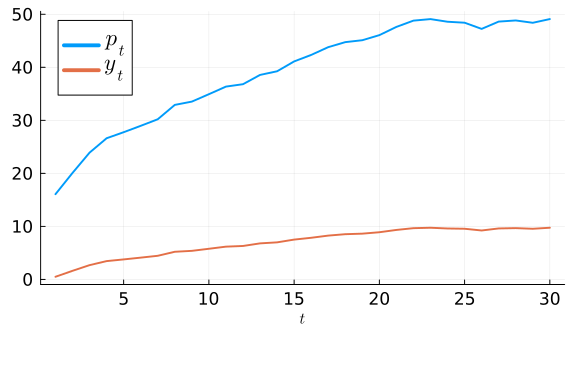

In [1]:
rho = 0.9
a = 1.0
sigma = 0.2
beta = 0.8
A = [rho a
     0 1]
C = [sigma; 0]
G = [1 0]
x_0 = [0.5, 1.0]
lss = LSS(A, C, G; mu_0 = x_0)
x, y = simulate(lss, 30)
H = G * inv(I - beta * A)
p = H * x
plot(p'; label = L"p_t",
     xlabel = L"t", size=(600, 400))
plot!(y', label = L"y_t")

## Example: Wages and Productivity

-   Wages $y_t = \theta z_t + (1-\theta) q_t$. Human capital:
    $\mathbb{E}[\sum_{j=0}^{\infty} \beta^j y_{t+j} | z_t, q_t]$
    -   Workers productivity follow
        $z_{t+1} = z_t + \alpha + \sigma w_{t+1}$ given $z_0$
    -   Firm productivity follows $q_{t+1} = q_t + \gamma$ given $q_0$
-   Guess a state of
    $x_t \equiv \begin{bmatrix}z_t & q_t & 1\end{bmatrix}^{\top}$ $$
    \begin{aligned}
    x_{t+1} &= \underbrace{\begin{bmatrix}1 & 0 & \alpha\\ 0 & 1 & \gamma\\ 0 & 0 & 1\end{bmatrix}}_{\equiv A} x_t + \underbrace{\begin{bmatrix}\sigma \\ 0 \\ 0\end{bmatrix}}_{\equiv C} w_{t+1}\\
    y_t &= \underbrace{\begin{bmatrix}\theta & 1-\theta & 0\end{bmatrix}}_{\equiv G} x_t
    \end{aligned}
    $$

## Simulation


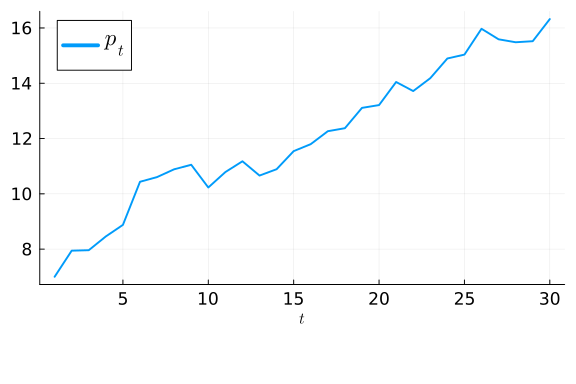

In [1]:
alpha, gamma = 0.1, 0.1
sigma = 0.2
theta = 0.5
beta = 0.8
A = [1 0 alpha
     0 1 gamma
     0 0 1]
C = [sigma; 0; 0] 
G = [theta 1-theta 0]
mu_0 = [1.0, 1.0, 1.0]
lss = LSS(A, C, G; mu_0)
x, y = simulate(lss, 30)
H = G * inv(I - beta * A)
p = H * x
plot(p'; label = L"p_t",
     xlabel = L"t", size=(600, 400))